# **Time Series Analysis: Stock Price Forecasting with Classical Time Series to Deep Learning Method**

Time Series is everywhere and we often meet. You may be able to see that in the data on the number of airplane passengers, weather predictions, stock price indexes, or during the pandemic the time series can be seen from the data on the number of people exposed to COVID-19.

Ok, maybe you are familiar with it. Now, what exactly is a time series?



A time series can be defined as a collection of consecutive observations or sequential over time. Each observation can be said to be correlated, where the current observation $X_t$ is influenced by the previous observation $X_{t-1}$. Thus, the order of the observations is important.

From the previous example, it is a univariate type of time series because it only consists of one type of observation at each time point. In addition, there are multivariate time series types, as the name implies, in this type, there is more than one observation at each point in time. For example, it is possible at a certain point in time to predict not only the weather but also temperature, and humidity, where wheater, temperature or humidity might influence each other.

One of the purposes of time series analysis is to forecast or predict the future. The analytical methods used can use methods from classical statistics to deep learning. For further details on this blog, analytical practice will be carried out, but only focus on univariate time series. We want to forecast the stock index of S&P 500, GSPC. Let's go to dirty our hands through this data!

# Import Data

The data used is S&P 500 Daily Close Stock Price sourced from [yahoo finance] which is taken from the period 2015 - 2022. For analysis I use Google Colab so I need to install and import the required libraries.

In [1]:
!pip install pmdarima
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 30.5 MB/s 
     |████████████████████████████████| 9.8 MB 48.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=31a34d587636e94de1dea3e9ade48a0609bbaf90e9cf89139d6f8ddb53d44891
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from prophet import Prophet

Next, import the data. Take the `Date` and `Close` columns for modeling. Perform data preprocessing by changing `Date` data format to datetime format.

In [5]:
df = pd.read_csv("/content/SP500.csv")
df = df[['Date', 'Close']]

df.loc[:, 'Date'] = pd.to_datetime(df.loc[:, 'Date'])

In [6]:
df.head()

,Date,Close
0,2015-01-02,2058.199951
1,2015-01-05,2020.579956
2,2015-01-06,2002.609985
3,2015-01-07,2025.900024
4,2015-01-08,2062.139893


# Dataset Splitting

The process of splitting data into sequential data cannot be done like the data splitting process in general modeling like using `train_test_split` on scikit-learn. Sequential data pay attention to the order so that at the time of splitting, shuffle data should not be carried out. We will split the data without shuffle as follows:

In [9]:
split_time = 1320
train = df[:split_time]
test = df[split_time:]

train.shape, test.shape

((1320, 2), (566, 2))

Before doing the analysis, let's see how the data looks like by plotting data:

In [11]:
#plot 1
pio.templates.default = "plotly_white"

st_fig = go.Figure()

line1 = go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train')
line2 = go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test')

st_fig.add_trace(line1)
st_fig.add_trace(line2)
st_fig.update_layout(title='Daily Close Stock Price S&P 500 Period 2015-2022')
st_fig.show()

From graphic, it can be seen that in general the data has an uptrend throughout the time period, although there are some fluctuation points caused by unexpected factors, such as the COVID 19 pandemic in early 2020 which had an impact on the decline in stock prices. To more clearly see the data can be decomposed as follows:

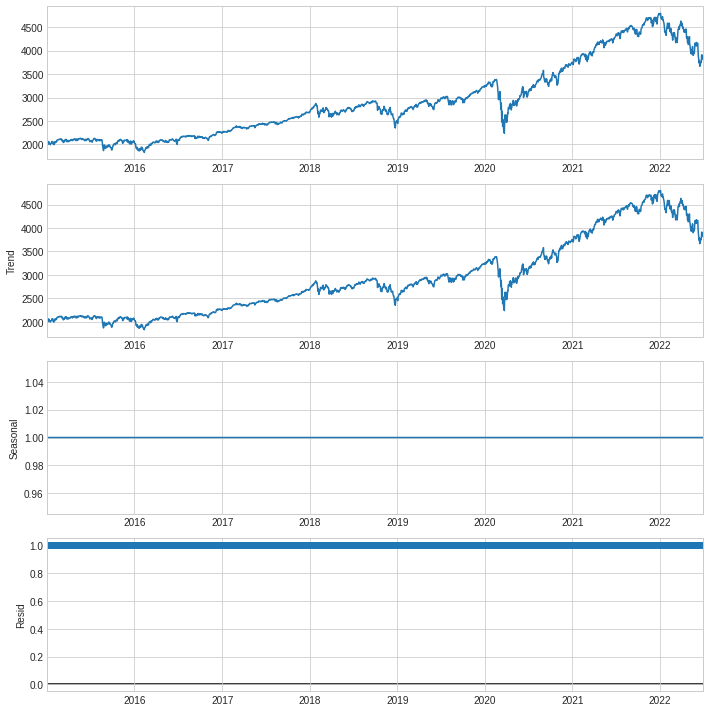

In [12]:
# plot 2
sd = df.copy().dropna()
sd.set_index('Date', inplace=True)

plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(10,10))

fig = seasonal_decompose(sd, model='multiplicative', period=1).plot()

fig.show()

# **ARIMA (Autoregressive Integrated Moving Average)**

ARIMA is one of the classical statistical analysis methods used for time series data. This method assumes the data used is stationary. In simple terms, it means that it has constant means and variance. Because the plot shows fluctuations and an upward trend, it is possible that this data is not stationary. To check the stationarity of the data, you can use the following ADF Test or KPSS Test:

**ADF Test**
- H0 : The series has a unit root (not stationary)
- H1 : The series is stationary

**KPSS Test**
- H0 : The series stationary
- H1 : The series has a unit root (not stationary)

In [13]:
result = adfuller(train['Close'])
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'])
print(f'KPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

ADF Stattistics : -1.5137955209748895
P-value : 0.526676189003344
KPSS Stattistics : 5.589890565622075
P-value : 0.01


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The results of the ADF Test p-value > $\alpha: 0.05$ so the conclusion is Accept H0, this means the data is not stationary. Likewise with the KPSS Test p-value < $\alpha: 0.05$ so the conclusion is Reject H0 which means the data is not stationary. The two tests result in the conclusion that the data is not stationary. To meet the assumptions, the data needed to be stationary.

How we can make data stationary?
You can do some tranformation or differencing data. For this analysis we will differencing data.

Determining the differencng order can be done by looking at the Autocorrelation Function (ACF) plot and the Partial Autocorrelation Function (PACF) plot.

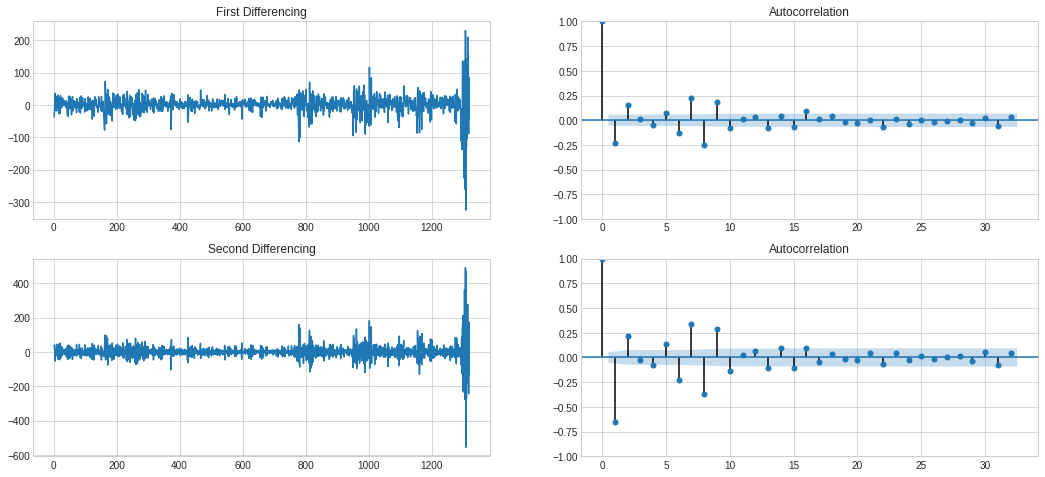

In [14]:
# Plot ACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_acf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_acf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



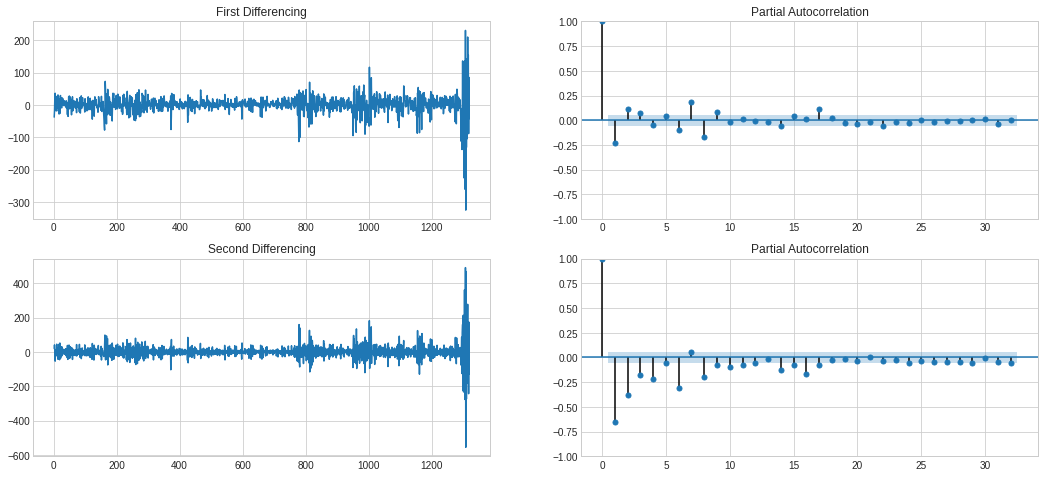

In [15]:
#Plot PACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_pacf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_pacf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

From the ACF and PACF plots above, it can be seen that when differencing is done 2 times, the value of lag 1 is increasingly negative. So that over differencing occurs, for that it is better to do differencing 1 time. To be sure, the determination of differencing can also be done through the following ADF Test:

In [16]:
ndiffs(train['Close'], test='adf')

1

The ADF Test results show a value of 1, so the differencing will be performed 1 time. To make sure the data is really stationary after differencing, the ADF and KPSS will be tested again.

In [17]:
result = adfuller(train['Close'].diff().dropna())
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'].diff().dropna())
print(f'\nKPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

if result[1] < 0.05 and result_kpss[1] > 0.05:
  print('\nConclusion : Data stationer\n')
else:
  print('\nConclusion : Data not stationer\n')

ADF Stattistics : -7.485163137144144
P-value : 4.6598258971285145e-11

KPSS Stattistics : 0.09300012592319162
P-value : 0.1

Conclusion : Data stationer



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Now we know that differencing the data 1 time make it stationary. 

The ARIMA model combines AR (Autoregressive) and MA (Moving Average) models with differencing. The ARIMA($q$, $d$, $p$) model requires order information for AR($q$) and MA($p$) and differencing ($d$). 

To determine the order of AR ($p$) you can use the PACF plot, while to determine the order of MA($q$) you can use the ACF plot. The value of $d$ has been previously determined, which is 1. Let's look again at the PACF and ACF plots after differencing 1 time.



/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



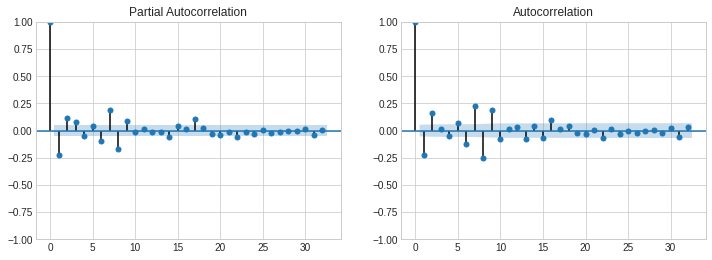

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

diff_once = train['Close'].diff()
plot_pacf(diff_once.dropna(), ax=ax[0])
plot_acf(diff_once.dropna(), ax=ax[1])

plt.show()

- From the PACF plot above, it can be seen that the PACF bar comes out until lag 1 so that the order from AR is $p=1$. 

- From the ACF plot above, it can be seen that the ACF bar also comes out to lag 1 so that the order from MA is $q=1$. 


So the ARIMA model chosen is ARIMA(1,1,1). For further comparison, a model with a lower order combination was selected than the main model, namely ARIMA(0,1,1) and ARIMA(1,1,0).

## Modeling

**ARIMA(1,1,1)**

In [19]:
model1 = ARIMA(train['Close'], order=(1, 1, 1), trend='t')
result1 = model1.fit()
print(result1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1320
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6268.075
Date:                Thu, 20 Oct 2022   AIC                          12544.150
Time:                        10:07:23   BIC                          12564.889
Sample:                             0   HQIC                         12551.926
                               - 1320                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3998      0.754      0.530      0.596      -1.078       1.877
ar.L1         -0.4625      0.029    -15.774      0.000      -0.520      -0.405
ma.L1          0.2414      0.033      7.303      0.0

From the results obtained, it can be seen that the resulting coefficient is not significant to the model. This can be seen from the confidence interval for each coefficient that contains a value of 0. For that we ignore the ARIMA(1,1,1) model, then let's look at the ARIMA(0,1,1) and ARIMA(1,1,1) models.


**ARIMA(0,1,1)**

In [20]:
model2 = ARIMA(train['Close'], order=(0, 1, 1), trend='t')
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1320
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6280.454
Date:                Thu, 20 Oct 2022   AIC                          12566.909
Time:                        10:07:28   BIC                          12582.463
Sample:                             0   HQIC                         12572.741
                               - 1320                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3991      0.741      0.539      0.590      -1.053       1.851
ma.L1         -0.1778      0.009    -20.068      0.000      -0.195      -0.160
sigma2       798.9841      9.349     85.462      0.0

**ARIMA(1,1,0)**

In [21]:
model3 = ARIMA(train['Close'], order=(1, 1, 0), trend='t')
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1320
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6272.613
Date:                Thu, 20 Oct 2022   AIC                          12551.225
Time:                        10:07:32   BIC                          12566.779
Sample:                             0   HQIC                         12557.057
                               - 1320                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3991      0.701      0.570      0.569      -0.974       1.773
ar.L1         -0.2278      0.008    -29.216      0.000      -0.243      -0.212
sigma2       790.5431      9.364     84.427      0.0

It turns out that from the results obtained, both ARIMA(0,1,1) and ARIMA(1,1,0) produce significant coefficients on the model. This can be seen from the confidence interval for each coefficient that does not contain a value of 0.

From the two models, the final model will be selected by looking at the AIC value of each model. The model with the smallest AIC value is the model that has the better performance. So the model with the smallest AIC is **ARIMA(0,1,1)** and this becomes the final model.

## Forecasting

The next step is to predict the test data and forecast for the next 100 days. Plot results of prediction and forecasting data.

In [22]:
#Prediction
prediction_arima = result1.get_prediction(start=1, end=len(df))
pred = prediction_arima.predicted_mean

pred_df = pd.DataFrame(pred.values, columns=['pred']).join(df['Date'])

In [23]:
#Forecast Next 100 Days
n_forecast = 100

forecast_arima = result1.get_forecast(steps=n_forecast)

yhat = forecast_arima.predicted_mean
yhat_conf_int = forecast_arima.conf_int(alpha=0.05)

yhat_date = pd.DataFrame(pd.date_range(start = '2022-07-01', periods = 100, freq='B'), columns=['Date'])

yhat_df = pd.DataFrame(yhat.values,  columns=['yhat']).join(yhat_date)

In [24]:
# Result Forecast
yhat_df

,yhat,Date
0,2600.546419,2022-07-01
1,2593.751436,2022-07-04
2,2597.478796,2022-07-05
3,2596.339637,2022-07-06
4,2597.451213,2022-07-07
...,...,...
95,2633.608994,2022-11-11
96,2634.008806,2022-11-14
97,2634.408617,2022-11-15
98,2634.808429,2022-11-16


In [25]:
lower_series = pd.DataFrame(yhat_conf_int['lower Close'].values, columns=['lower']).join(yhat_date)
upper_series = pd.DataFrame(yhat_conf_int['upper Close'].values, columns=['upper']).join(yhat_date)

In [26]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = pred_df['Date'], y = pred_df['pred'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Prediction'))
st_fig.add_trace(go.Scatter(x = yhat_df['Date'], y = yhat_df['yhat'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Forecasting'))

st_fig.add_traces(go.Scatter(x=lower_series['Date'], y = lower_series['lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=upper_series['Date'], y = upper_series['upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.update_layout(title='ARIMA (0,1,1)')
st_fig.show()

## Evaluation

Next, evaluate the model based on the prediction results on the test data and the actual test data using the RMSE (Root Mean Squared Error) metric.

In [27]:
rmse_arima =  mean_squared_error(test['Close'], pred_df['pred'][split_time:], squared=False)
rmse_arima

1327.56250758654

# Long Short Term Memory (LSTM)

Next, we will use deep learning methods for analysis. In general, the use of deep learning methods uses a neural network model. One of the neural network models used to train sequential data types is the Recurrent Neural Network (RNN). In its development, RNN has a drawback that the model cannot predict data based on information that has been stored for a long time. Thus, LSTM is present as a modification of the RNN model to complete these shortcomings. The LSTM model is able to remember data/information that has been stored for a long time and delete irrelevant data/information for further use.

In general, the Neural network model trains data as supervised learning, meaning that the model requires predictors data and target data. However, the problem is in time series data, it does not have predictors and target components. So we need to modify the data, next we will introduce the concept of **window size**.

Window size is the number of features (predictors) that will be used to predict the target. In other words, numbers from the previous time data are used to predict the next day. For example, if we specify window size = 2, then to predict tomorrow (target) we need today's and yesterday's data (predictors).

Suppose we have time series data as follows: $[1,2,3,4,5,6,7,8,9]$


Next we choose window size = 5, then the required data format is as follows:

$[1, 2, 3, 4, 5] [6]$

$[2, 3, 4, 5, 6] [7]$

$[3, 4, 5, 6, 7] [8]$

$[4, 5, 6, 7, 8] [9]$

To prepare data in the required format, we can use the Tensorflow module, namely [TimeseriesGenerator](https://www.tensorflow.org/api_docs/python/tf/cepat/preprocessing/sequence/TimeseriesGenerator).

In [28]:
# Prepare Dataset

scaler = StandardScaler()
train_scale = pd.DataFrame(scaler.fit_transform(np.array(train['Close']).reshape(-1,1)), columns=['Close'])
train_scale_df = train[['Date']].join(train_scale)

test_scale = pd.DataFrame(scaler.transform(np.array(test['Close']).reshape(-1,1)), index=test.index, columns=['Close'])
test_scale_df = test[['Date']].join(test_scale)

In [29]:
window_size=10

train_generator = TimeseriesGenerator(train_scale_df['Close'].to_numpy(), 
                                      train_scale_df['Close'].to_numpy(), length=window_size, batch_size=28)  
   
test_generator = TimeseriesGenerator(test_scale_df['Close'].to_numpy(), 
                                     test_scale_df['Close'].to_numpy(), length=window_size, batch_size=1)

## Modeling

In [30]:
# Modeling
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(100, input_shape=(window_size,1), return_sequences=True),
        tf.keras.layers.LSTM(50, return_sequences=True),
        tf.keras.layers.LSTM(10),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mape'])

history = model.fit(train_generator,epochs=100)

Epoch 1/100
47/47 [==============================] - 7s 18ms/step - loss: 0.5466 - mape: 189.2248
Epoch 2/100
47/47 [==============================] - 1s 21ms/step - loss: 0.1262 - mape: 173.1886
Epoch 3/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0902 - mape: 232.7610
Epoch 4/100
47/47 [==============================] - 1s 21ms/step - loss: 0.0708 - mape: 184.2425
Epoch 5/100
47/47 [==============================] - 1s 19ms/step - loss: 0.0393 - mape: 164.5536
Epoch 6/100
47/47 [==============================] - 1s 19ms/step - loss: 0.0383 - mape: 155.8423
Epoch 7/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0344 - mape: 157.0675
Epoch 8/100
47/47 [==============================] - 1s 18ms/step - loss: 0.0394 - mape: 202.8258
Epoch 9/100
47/47 [==============================] - 1s 17ms/step - loss: 0.0330 - mape: 163.4896
Epoch 10/100
47/47 [==============================] - 1s 18ms/step - loss: 0.0288 - mape: 148.1304
Epoch 11/100
47/47 

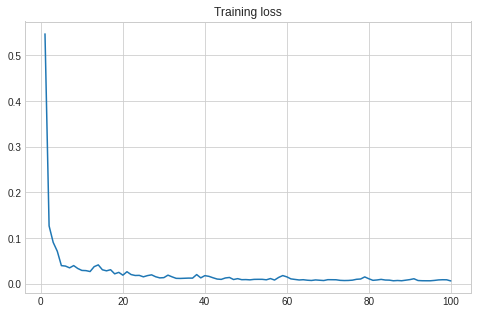

In [31]:
plt.figure(figsize=(8,5))

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss)
plt.title('Training loss')

plt.show()

In [32]:
#Prediction

train_predict = model.predict(train_generator)
train_predict = pd.DataFrame(scaler.inverse_transform(train_predict.reshape(-1,1)), columns=['Close'])

test_predict = model.predict(test_generator)
test_predict = pd.DataFrame(scaler.inverse_transform(test_predict.reshape(-1,1)), columns=['Close'])

556/556 [==============================] - 3s 6ms/step


In [34]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = train['Date'][10:], y = train_predict['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Train Prediction'))
st_fig.add_trace(go.Scatter(x = test['Date'][10:], y = test_predict['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Test Prediction'))


st_fig.update_layout(title='LSTM')
st_fig.show()

## Forecasting

The next step is to forecast for the next 100 days. Plot results of forecasting data.

In [37]:
# Forcasting

def predict(num_prediction, model):
    prediction_list = test_scale['Close'].to_numpy()[-window_size:]

    for _ in range(num_prediction):
      x = prediction_list[-window_size:]
      x = x.reshape(1, window_size, 1)
      out = model.predict(x)
      prediction_list = np.append(prediction_list, out)

    forecast = prediction_list[window_size:]
    forecast = pd.DataFrame(scaler.inverse_transform(forecast.reshape(-1,1)), columns=['Close'])
    forecast['Date'] = pd.date_range(start = test['Date'].to_list()[-1] + pd.DateOffset(days=1), periods = num_prediction, freq='B')

    return forecast

In [36]:
forecast_lstm = predict(100, model)

1/1 [==============================] - 0s 18ms/step


In [38]:
# Result Forecast
forecast_lstm

,Close,Date
0,3611.389235,2022-06-30
1,3498.826701,2022-07-01
2,3383.893986,2022-07-04
3,3324.024205,2022-07-05
4,3317.290807,2022-07-06
...,...,...
95,3337.155230,2022-11-10
96,3337.155230,2022-11-11
97,3337.155230,2022-11-14
98,3337.155230,2022-11-15


In [39]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = train['Date'][10:], y = train_predict['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Train Prediction'))
st_fig.add_trace(go.Scatter(x = test['Date'][10:], y = test_predict['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Test Prediction'))

st_fig.add_trace(go.Scatter(x = forecast_lstm['Date'], y = forecast_lstm['Close'], 
                            line = dict(color='#5d05f5', width=2, dash='dot'), name= 'Forecast'))


st_fig.update_layout(title='LSTM + Forecast')
st_fig.show()

## Evaluation

Next, evaluate the model based on the prediction results on the test data and the actual test data using the RMSE (Root Mean Squared Error) metric.

In [40]:
rmse_lstm =  mean_squared_error(test['Close'][10:], test_predict['Close'], squared=False)
rmse_lstm

457.4982505311901

# FB Prophet Model

In addition to the above models, there is a popular forecasting model used, namely the [FB Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api). Prophet is open source software released by Facebook's Core Data Science team in 2017. Prophet model based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

To use this model, we need to prepare the data according to the required format. Where the data must consist of columns `ds` (datesamp) and `y` (observation). It should be noted that the column naming must also match the format, and for ds the format used is YYYY-MM-DD. Ok, Let's prepare the data!

In [41]:
train_fp = pd.DataFrame({'ds' : train['Date'], 'y' : train['Close']})

train_fp.head()

,ds,y
0,2015-01-02,2058.199951
1,2015-01-05,2020.579956
2,2015-01-06,2002.609985
3,2015-01-07,2025.900024
4,2015-01-08,2062.139893


## Modeling

Then do the modeling, because our data is in the form of daily, we set `daily_seasonality=True`.

In [42]:
model_fp = Prophet(daily_seasonality=True)
model_fp.fit(train_fp)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnrqges2q/5o47laoj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnrqges2q/qdq3w1g1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8800', 'data', 'file=/tmp/tmpnrqges2q/5o47laoj.json', 'init=/tmp/tmpnrqges2q/qdq3w1g1.json', 'output', 'file=/tmp/tmpnrqges2q/prophet_model24urbq0g/prophet_model-20221020101543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Forecasting

Then do forecasting for test data and the next 100 days and plot the results.

In [43]:
future = model_fp.make_future_dataframe(periods=len(test)+100, freq='B')
future.tail()

,ds
1981,2022-10-13
1982,2022-10-14
1983,2022-10-17
1984,2022-10-18
1985,2022-10-19


In [44]:
forecast = model_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1981,2022-10-13,3980.824459,3369.966993,4535.294628
1982,2022-10-14,3979.773573,3383.528442,4534.893700
1983,2022-10-17,3978.144493,3389.696101,4566.532335
1984,2022-10-18,3983.315027,3371.293046,4554.276974
1985,2022-10-19,3984.325579,3378.459148,4532.210344


In [45]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()


st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = forecast['ds'], y = forecast['yhat'], 
                            line = dict(color='green', width=2, dash='dot'), name= 'Forecasting'))


st_fig.update_layout(title='FB Prophet')
st_fig.show()

In addition, Prophet also provides its own function to plot forecast results as follows:

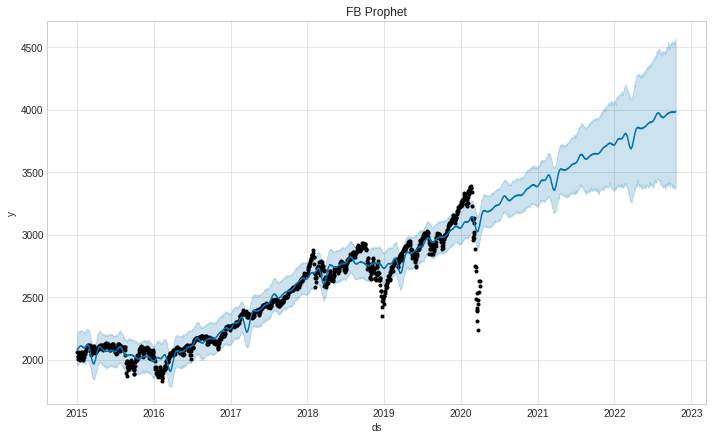

In [46]:
model_fp.plot(forecast)
plt.title('FB Prophet')
plt.show()

## Evaluation

Next, evaluate the model based on the prediction results on the test data and the actual test data using the RMSE (Root Mean Squared Error) metric.

In [47]:
rmse_fp =  mean_squared_error(test['Close'], forecast['yhat'][split_time:split_time+len(test)], squared=False)
rmse_fp

584.1704574310239

# Summary

In [48]:
pd.DataFrame({'Model' : ['ARIMA', 'LSTM', 'FB Prophet'],
              'RMSE Test Set': [rmse_arima, rmse_lstm, rmse_fp]})

,Model,RMSE Test Set
0,ARIMA,1327.562508
1,LSTM,457.498251
2,FB Prophet,584.170457


The smallest rmse value is obtained by the LSTM model. It can be said that this model has a better performance to predict the daily stock index of S&P 500. For more complete code, see my [github](https://github.dev/alamgirhossain-tech).

That's all our hands-on for time series analysis, especially for univariate time series. The writing on this blog is certainly not perfect and there may still have deficiencies. 

Of course, I'm also still in the learning stage, thank you for reading, I hope it's useful, I'd love, if you comment for any suggestions and hopefully we can learn together. You can also be connected with me on [LinkedIn](https://www.linkedin.com/in/hossain-alamgir/) ^^. 